In [1]:
!pip install econml

/bin/bash: /anaconda/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from nlp_data_handle import *
from transformer_debugger import *

2023-01-11 09:52:16.459740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 09:52:16.631041: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-11 09:52:17.225605: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/

In [3]:
def get_nlptoy2_dataset(pvalt0,pvalt1,num_sample,noise_ratio):

    #Creating the data args
    data_args=dict(
                run_num = 1,
                emb_path= "glove-wiki-gigaword-100",
                topic_corr_list=[pvalt0,pvalt1],
                num_sample=num_sample,
                noise_ratio=noise_ratio,
                main_model_mode="non_causal", 
                transformer_name="bert-base-uncased",
                max_len=50,
                num_topics=2,
                expt_meta_path="logs_nlptoy2",
                dtype="toynlp2"
    )
    data_handler = DataHandleTransformer(data_args)
    cat_fulldict = data_handler.toy_nlp_dataset_handler2(return_fulldict=True)
    
    return cat_fulldict,data_args,data_handler

In [10]:
def get_nlptoy3_dataset(pvaltsp,num_sample,noise_ratio):

    #Creating the data args
    data_args=dict(
                run_num = 1,
                emb_path= "glove-wiki-gigaword-100",
#                 topic_corr_list=[pvalt0,pvalt1],
                num_sample=num_sample,
                noise_ratio=noise_ratio,
                main_model_mode="non_causal", 
                transformer_name="bert-base-uncased",
                max_len=50,
                num_topics=2,
                expt_meta_path="logs_nlptoy2",
                dtype="toynlp2",
                sp_topic_pval=pvaltsp,
                return_label_dataset=False,
                concat_word_emb=False,
    )
    data_handler = DataHandleTransformer(data_args)
    label_dict,label_corr_dict,all_example_widx_dict = data_handler.toy_nlp_dataset_handler3(return_fulldict=True)
    
    return label_dict,label_corr_dict,all_example_widx_dict,data_args,data_handler

In [12]:
def get_nbowX_embedding(X_input_idx,data_args,data_handler,num_hidden_layer,lr):
    model_args=dict(
                train_emb=False,
                normalize_emb=True,
                num_hidden_layer=num_hidden_layer,
                bert_as_encoder=False,
                loss_type="x_entropy",
                l2_lambd=0.0,
                removal_mode=None,
                lr=lr,
                treated_topic=treated_topic,
                stage_mode="stage1_econml",
                concat_word_emb=False,

    )
    classifier_main = SimpleNBOW(data_args,model_args,data_handler)
    classifier_main.compile(
            keras.optimizers.Adam(learning_rate=model_args["lr"])
    )


    #Getting the X-embedding form the text
#     X_input_idx = cat_fulldict["input_idx"]
    X_emb = classifier_main.pre_encoder_layer(X_input_idx,None).numpy()
    
    return X_emb,model_args

## Linear DML Estimator

In [5]:
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV,LinearRegression,
                                 )
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,RandomForestClassifier



def get_linear_dml_estimate(pvalt0,pvalt1,num_sample,noise_ratio,num_hidden_layer,lr,treated_topic):
    #Getting the dataset raw
    cat_fulldict,data_args,data_handle = get_nlptoy2_dataset(pvalt0,pvalt1,num_sample,noise_ratio)
    
    #Getting the dataset for the estimation
    print("Getting the embedding of the input!")
    X_emb,model_args = get_nbowX_embedding(cat_fulldict["input_idx"],data_args,data_handle,num_hidden_layer,lr)
    
    X = X_emb
    Y = cat_fulldict["label"]
    T = cat_fulldict["topic_label"][:,model_args["treated_topic"]]
    
    

    #Creating the estimator
#     est = LinearDML(
#                 model_y = LinearRegression,#RandomForestRegressor(),
#                 model_t = LogisticRegression,#RandomForestClassifier(min_samples_leaf=10),
#                 discrete_treatment=True,
#                 linear_first_stages=False,#Is it true
#                 cv=6,
#     )
    
    print("Getting the Causal Effect Estimate!")
    #Causal Forest Regressor
    est = CausalForestDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestClassifier(min_samples_leaf=10),
                       discrete_treatment=True,
                       n_estimators=100,
                       min_impurity_decrease=0.001,
                       verbose=0,
                       cv=6)
    
    
    est.fit(Y,T,X=X,W=X)
    print("ATE: ",np.mean(est.effect(X)))

    #Getting the interval
    lb,ub = est.effect_interval(X, alpha=0.01)
    print("ATE: ub,lb = ",np.mean(lb),", ",np.mean(ub))
    
    result_dict = dict(
            ate=np.mean(est.effect(X)),
            lb=np.mean(lb),
            ub=np.mean(ub)
    )
    
    return result_dict

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 4]



def plot_one_pval_var(ax,pvaltmain,pvalsp_list,ate,ate_lb,ate_ub,treated_topic,noise_ratio):
    #Plotting the mean line for a particular treatment and topic
    ax.plot(pvalsp_list,ate,marker="o",ls="-.",label="topic={}".format(treated_topic))
    ax.fill_between(pvalsp_list,ate_lb,ate_ub,alpha=0.3)
    
    #Filling the plot details
    ax.set_ylabel("ATE")
    ax.set_xlabel("spurious pval [0.5,0.99)")
    ax.legend()
    ax.grid(True)
    ax.set_title("pvaltmain={}".format(pvaltmain))
#     ax.set_title("noise={}".format(noise_ratio))
#     ax.set_ylim(-1,1)
    
    

def plot_one_result_set(all_result_dict,pvalt0_list,pvalt1_list,treated_topics,num_sample,noise_list):
#     fig,ax = plt.subplots(1,len(noise_list))
    fig,ax = plt.subplots(1,len(pvalt0_list))
    
    for nidx,noise_ratio in enumerate(noise_list):
        for pidx0,pvalt0 in enumerate(pvalt0_list):
            for tidx,treated_topic in enumerate(treated_topics):
                #Collecting the results for each pval
                ate = [all_result_dict[(num_sample,noise_ratio,pvalt0,pval,treated_topic)]["ate"] for pval in pvalt1_list]
                ate_lb = [all_result_dict[(num_sample,noise_ratio,pvalt0,pval,treated_topic)]["lb"] for pval in pvalt1_list]
                ate_ub = [all_result_dict[(num_sample,noise_ratio,pvalt0,pval,treated_topic)]["ub"] for pval in pvalt1_list]

                #Plotting for this treated topic
#                 plot_one_pval_var(ax[nidx],pval_list,ate,ate_lb,ate_ub,treated_topic,noise_ratio)
                plot_one_pval_var(ax[pidx0],pvalt0,pvalt1_list,ate,ate_lb,ate_ub,treated_topic,noise_ratio)
    
    plt.show()

In [40]:
#Running the full experiment
num_sample_list = [1000,]
noise_list=[0.0,]
pvalt0_list=[0.7,]
pvalt1_list =[0.5,0.6,0.7,0.8,0.9,0.99]
treated_topics=[0,1]

#Not being used
num_hidden_layer=0
lr=5e-3


all_result_dict=dict()

for num_sample in num_sample_list:
    for noise_ratio in noise_list:
        for pvalt0 in pvalt0_list:
            for pvalt1 in pvalt1_list:
                for treated_topic in treated_topics:
                    print("Getting the causal effect estimate for: treat_topic:{}\tpvalt0:{}\tpvalt1:{}".format(treated_topic,pvalt0,pvalt1))
                    #Getting the estimate of the 
                    result_dict=get_linear_dml_estimate(pvalt0,pvalt1,num_sample,noise_ratio,num_hidden_layer,lr,treated_topic)
                    #Collecting the results
                    all_result_dict[(num_sample,noise_ratio,pvalt0,pvalt1,treated_topic)]=result_dict

            
        

Getting the causal effect estimate for: treat_topic:0	pvalt0:0.7	pvalt1:0.5
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.73
iidx:0	jidx:2	corr:0.49
iidx:1	jidx:2	corr:0.50
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  2.974178515155467
ATE: ub,lb =  -3.6329611063830383 ,  9.581318136693971
Getting the causal effect estimate for: treat_topic:1	pvalt0:0.7	pvalt1:0.5
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.73
iidx:0	jidx:2	corr:0.49
iidx:1	jidx:2	corr:0.50
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.17383119539679692
ATE: ub,lb =  -3.306490846796376 ,  3.6541532375899686
Getting the causal effect estimate for: treat_topic:0	pvalt0:0.7	pvalt1:0.6
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.73
iidx:0	jidx:2	corr:0.60
iidx:1	jidx:2	corr:0.57
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  3.0037937526327583
ATE: ub,lb =  -3.627375340689538 ,  9.634962845955053
Getting the causal effect estimate for: treat_topic:1	pvalt0:0.7	pvalt1:0.6
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.73
iidx:0	jidx:2	corr:0.60
iidx:1	jidx:2	corr:0.57
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.39623148292105315
ATE: ub,lb =  -2.9397704245084806 ,  3.732233390350587
Getting the causal effect estimate for: treat_topic:0	pvalt0:0.7	pvalt1:0.7
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.73
iidx:0	jidx:2	corr:0.71
iidx:1	jidx:2	corr:0.62
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  2.2654777160359636
ATE: ub,lb =  -4.099890157316105 ,  8.63084558938803
Getting the causal effect estimate for: treat_topic:1	pvalt0:0.7	pvalt1:0.7
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.73
iidx:0	jidx:2	corr:0.71
iidx:1	jidx:2	corr:0.62
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.8931199798710762
ATE: ub,lb =  -2.3111536706443596 ,  4.09739363038651
Getting the causal effect estimate for: treat_topic:0	pvalt0:0.7	pvalt1:0.8
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.73
iidx:0	jidx:2	corr:0.81
iidx:1	jidx:2	corr:0.66
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  1.4331301107524863
ATE: ub,lb =  -4.0841045826975915 ,  6.950364804202564
Getting the causal effect estimate for: treat_topic:1	pvalt0:0.7	pvalt1:0.8
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.73
iidx:0	jidx:2	corr:0.81
iidx:1	jidx:2	corr:0.66
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  1.0748262720174548
ATE: ub,lb =  -1.357231624489296 ,  3.5068841685242047
Getting the causal effect estimate for: treat_topic:0	pvalt0:0.7	pvalt1:0.9
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.73
iidx:0	jidx:2	corr:0.91
iidx:1	jidx:2	corr:0.69
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.2893412725360602
ATE: ub,lb =  -2.8964532224047943 ,  3.4751357674769134
Getting the causal effect estimate for: treat_topic:1	pvalt0:0.7	pvalt1:0.9
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.73
iidx:0	jidx:2	corr:0.91
iidx:1	jidx:2	corr:0.69
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  1.1810767446255714
ATE: ub,lb =  -0.19355477251353775 ,  2.5557082617646807
Getting the causal effect estimate for: treat_topic:0	pvalt0:0.7	pvalt1:0.99
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.73
iidx:0	jidx:2	corr:0.99
iidx:1	jidx:2	corr:0.73
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.06850187080691211
ATE: ub,lb =  -0.5355832582726061 ,  0.6725869998864301
Getting the causal effect estimate for: treat_topic:1	pvalt0:0.7	pvalt1:0.99
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.73
iidx:0	jidx:2	corr:0.99
iidx:1	jidx:2	corr:0.73
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.8805821946798191
ATE: ub,lb =  0.5500358234502459 ,  1.211128565909392


# Running experiment on dataset 3

In [6]:
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV,LinearRegression,
                                 )
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures


def get_linear_dml_estimate_toy3(pvaltsp,num_sample,noise_ratio,num_hidden_layer,lr,treated_topic,x_is_sentence=False):
    #Getting the dataset raw
    label_dict,label_corr_dict,all_example_widx_dict,data_args,data_handle = get_nlptoy3_dataset(pvaltsp,num_sample,noise_ratio)
       
    
    W = np.expand_dims(label_dict["topic_label"][:,1],axis=-1) #The confounder
    Y = label_dict["y"] #the main task label
#     T = np.expand_dims(label_dict["topic_label"][:,treated_topic],axis=-1) #0:causal, 1: confounder, 2: spurious
    T = label_dict["topic_label"][:,treated_topic]
    if x_is_sentence:
        #Getting the dataset for the estimation
        print("Getting the embedding of the input!")
        if treated_topic==0:
            X_emb,_ = get_nbowX_embedding(all_example_widx_dict["all_example_notreat_causal_widx_list"],data_args,data_handle,num_hidden_layer,lr)
        elif treated_topic==1:
            X_emb,_ = get_nbowX_embedding(all_example_widx_dict["all_example_notreat_confound_widx_list"],data_args,data_handle,num_hidden_layer,lr)
        elif treated_topic==2:
            X_emb,_ = get_nbowX_embedding(all_example_widx_dict["all_example_notreat_spurious_widx_list"],data_args,data_handle,num_hidden_layer,lr)
        #Using the Xemb as the covariate
        X = X_emb
    else:
        X = np.delete(label_dict["topic_label"],treated_topic,axis=1)
    

    #Creating the estimator
#     print("Getting the Causal Effect Estimate!")
#     est = LinearDML(
#                 model_y = RandomForestRegressor(),#LinearRegression,#RandomForestRegressor(),
#                 model_t = RandomForestClassifier(),#LogisticRegression,#RandomForestClassifier(min_samples_leaf=10),
#                 discrete_treatment=True,
#                 linear_first_stages=True,#Is it true
#                 cv=6,
#     )
    
    print("Getting the Causal Effect Estimate!")
    #Causal Forest Regressor
    est = CausalForestDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestClassifier(min_samples_leaf=10),
                       discrete_treatment=True,
                       n_estimators=100,
                       min_impurity_decrease=0.001,
                       verbose=0,
                       cv=6)

#     est = SparseLinearDML(model_y=RandomForestRegressor(),
#                        model_t=RandomForestClassifier(min_samples_leaf=10),
#                        discrete_treatment=True,
#                        featurizer=PolynomialFeatures(degree=2),
#                        linear_first_stages=False,
#                        cv=6)
    

    est.fit(Y,T,X=X)
    
    #TODO: Create different train and valid split here also
    print("ATE: ",np.mean(est.effect(X)))

    #Getting the interval
    lb,ub = est.effect_interval(X, alpha=0.01)
    print("ATE: ub,lb = ",np.mean(lb),", ",np.mean(ub))
    
    result_dict = dict(
            ate=np.mean(est.effect(X)),
            lb=np.mean(lb),
            ub=np.mean(ub)
    )
    
    return result_dict,label_corr_dict

In [13]:
#Running the full experiment
num_sample_list = [1000,]
noise_list=[0.0]
pvaltsp_list =[0.5,0.6,0.7,0.8,0.9,0.99]
treated_topics=[0,1,2]

#Not being used
num_hidden_layer=0
lr=5e-3
x_is_sentence=True


all_result_dict_toy3=dict()
all_label_corr_dict_toy3=dict()

for num_sample in num_sample_list:
    for noise_ratio in noise_list:
        for pvaltsp in pvaltsp_list:
            for treated_topic in treated_topics:
                print("Getting the causal effect estimate for: treat_topic:{}\tpvaltsp:{}".format(treated_topic,pvaltsp))
                #Getting the estimate of the 
                result_dict,label_corr_dict=get_linear_dml_estimate_toy3(pvaltsp,num_sample,noise_ratio,num_hidden_layer,lr,treated_topic,x_is_sentence=x_is_sentence)
                #Collecting the results
                all_result_dict_toy3[(num_sample,noise_ratio,pvaltsp,treated_topic)]=result_dict
                all_label_corr_dict_toy3[(num_sample,noise_ratio,pvaltsp)]=label_corr_dict

Getting the causal effect estimate for: treat_topic:0	pvaltsp:0.5


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.49
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.50


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.49
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.50
Creating the dataset
Loading the embedding!
Loading the WordVectors via Gensim! Hold Tight!
Getting the embedding of the input!
Dumping the config in: logs_nlptoy2/config.json
Getting the Causal Effect Estimate!


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.28729588448026966
ATE: ub,lb =  0.06278440673117362 ,  0.5118073622293656
Getting the causal effect estimate for: treat_topic:1	pvaltsp:0.5


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.49
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.50


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.49
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.50
Creating the dataset
Loading the embedding!
Loading the WordVectors via Gensim! Hold Tight!
Getting the embedding of the input!
Dumping the config in: logs_nlptoy2/config.json
Getting the Causal Effect Estimate!


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.5170543488392687
ATE: ub,lb =  0.3280189296261509 ,  0.7060897680523864
Getting the causal effect estimate for: treat_topic:2	pvaltsp:0.5


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.49
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.50


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.49
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.50
Creating the dataset
Loading the embedding!
Loading the WordVectors via Gensim! Hold Tight!
Getting the embedding of the input!
Dumping the config in: logs_nlptoy2/config.json
Getting the Causal Effect Estimate!


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  -0.1078042172910103
ATE: ub,lb =  -1.6898232474609653 ,  1.4742148128789445
Getting the causal effect estimate for: treat_topic:0	pvaltsp:0.6


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.53
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.60


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.53
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.60
Creating the dataset
Loading the embedding!
Loading the WordVectors via Gensim! Hold Tight!
Getting the embedding of the input!
Dumping the config in: logs_nlptoy2/config.json
Getting the Causal Effect Estimate!


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.30361664554057616
ATE: ub,lb =  0.08544756162496148 ,  0.5217857294561907
Getting the causal effect estimate for: treat_topic:1	pvaltsp:0.6


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.53
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.60


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.53
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.60
Creating the dataset
Loading the embedding!
Loading the WordVectors via Gensim! Hold Tight!
Getting the embedding of the input!
Dumping the config in: logs_nlptoy2/config.json
Getting the Causal Effect Estimate!


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.5121512141567581
ATE: ub,lb =  0.31928938948635427 ,  0.7050130388271619
Getting the causal effect estimate for: treat_topic:2	pvaltsp:0.6


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.53
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.60


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.53
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.60
Creating the dataset
Loading the embedding!
Loading the WordVectors via Gensim! Hold Tight!
Getting the embedding of the input!
Dumping the config in: logs_nlptoy2/config.json
Getting the Causal Effect Estimate!


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.028007030806821938
ATE: ub,lb =  -1.5392585826034781 ,  1.5952726442171214
Getting the causal effect estimate for: treat_topic:0	pvaltsp:0.7


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.58
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.70


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.58
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.70
Creating the dataset
Loading the embedding!
Loading the WordVectors via Gensim! Hold Tight!
Getting the embedding of the input!
Dumping the config in: logs_nlptoy2/config.json
Getting the Causal Effect Estimate!


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.29047647222768297
ATE: ub,lb =  0.07382431570251066 ,  0.5071286287528551
Getting the causal effect estimate for: treat_topic:1	pvaltsp:0.7


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.58
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.70


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.58
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.70
Creating the dataset
Loading the embedding!
Loading the WordVectors via Gensim! Hold Tight!
Getting the embedding of the input!
Dumping the config in: logs_nlptoy2/config.json
Getting the Causal Effect Estimate!


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.5358265308265011
ATE: ub,lb =  0.3310642428903069 ,  0.7405888187626953
Getting the causal effect estimate for: treat_topic:2	pvaltsp:0.7


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.58
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.70


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.58
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.70
Creating the dataset
Loading the embedding!
Loading the WordVectors via Gensim! Hold Tight!
Getting the embedding of the input!
Dumping the config in: logs_nlptoy2/config.json
Getting the Causal Effect Estimate!


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.03505110023906917
ATE: ub,lb =  -1.5507675890593635 ,  1.6208697895375017
Getting the causal effect estimate for: treat_topic:0	pvaltsp:0.8


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.65
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.80


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.65
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.80
Creating the dataset
Loading the embedding!
Loading the WordVectors via Gensim! Hold Tight!
Getting the embedding of the input!
Dumping the config in: logs_nlptoy2/config.json
Getting the Causal Effect Estimate!


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.30158962537982426
ATE: ub,lb =  0.08934074442634984 ,  0.5138385063332988
Getting the causal effect estimate for: treat_topic:1	pvaltsp:0.8


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.65
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.80


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.65
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.80
Creating the dataset
Loading the embedding!
Loading the WordVectors via Gensim! Hold Tight!
Getting the embedding of the input!
Dumping the config in: logs_nlptoy2/config.json
Getting the Causal Effect Estimate!


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.5140891280314643
ATE: ub,lb =  0.27360449174762125 ,  0.7545737643153074
Getting the causal effect estimate for: treat_topic:2	pvaltsp:0.8


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.65
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.80


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.65
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.80
Creating the dataset
Loading the embedding!
Loading the WordVectors via Gensim! Hold Tight!
Getting the embedding of the input!
Dumping the config in: logs_nlptoy2/config.json
Getting the Causal Effect Estimate!


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.27922408363658985
ATE: ub,lb =  -1.397615121950077 ,  1.9560632892232566
Getting the causal effect estimate for: treat_topic:0	pvaltsp:0.9


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.69
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.90


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.69
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.90
Creating the dataset
Loading the embedding!
Loading the WordVectors via Gensim! Hold Tight!
Getting the embedding of the input!
Dumping the config in: logs_nlptoy2/config.json
Getting the Causal Effect Estimate!


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.3056100062650345
ATE: ub,lb =  0.10394750334373563 ,  0.5072725091863334
Getting the causal effect estimate for: treat_topic:1	pvaltsp:0.9


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.69
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.90


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.69
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.90
Creating the dataset
Loading the embedding!
Loading the WordVectors via Gensim! Hold Tight!
Getting the embedding of the input!
Dumping the config in: logs_nlptoy2/config.json
Getting the Causal Effect Estimate!


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.5477085533384063
ATE: ub,lb =  0.24631894354137557 ,  0.8490981631354368
Getting the causal effect estimate for: treat_topic:2	pvaltsp:0.9


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.69
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.90


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.69
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.90
Creating the dataset
Loading the embedding!
Loading the WordVectors via Gensim! Hold Tight!
Getting the embedding of the input!
Dumping the config in: logs_nlptoy2/config.json
Getting the Causal Effect Estimate!


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.4532713268599354
ATE: ub,lb =  -1.0917579457659172 ,  1.9983005994857874
Getting the causal effect estimate for: treat_topic:0	pvaltsp:0.99


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.75
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.99


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.75
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.99
Creating the dataset
Loading the embedding!
Loading the WordVectors via Gensim! Hold Tight!
Getting the embedding of the input!
Dumping the config in: logs_nlptoy2/config.json
Getting the Causal Effect Estimate!


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.309494328465871
ATE: ub,lb =  0.11761606391050591 ,  0.5013725930212359
Getting the causal effect estimate for: treat_topic:1	pvaltsp:0.99


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.75
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.99


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.75
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.99
Creating the dataset
Loading the embedding!
Loading the WordVectors via Gensim! Hold Tight!
Getting the embedding of the input!
Dumping the config in: logs_nlptoy2/config.json
Getting the Causal Effect Estimate!


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.46711876214783116
ATE: ub,lb =  -0.12713831360880073 ,  1.0613758379044629
Getting the causal effect estimate for: treat_topic:2	pvaltsp:0.99


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.75
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.99


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.65
iidx:0	jidx:2	corr:0.76
iidx:0	jidx:3	corr:0.75
iidx:1	jidx:2	corr:0.50
iidx:1	jidx:3	corr:0.50
iidx:2	jidx:3	corr:0.99
Creating the dataset
Loading the embedding!
Loading the WordVectors via Gensim! Hold Tight!
Getting the embedding of the input!
Dumping the config in: logs_nlptoy2/config.json
Getting the Causal Effect Estimate!


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.5423382039772103
ATE: ub,lb =  -0.8861890600040526 ,  1.9708654679584734


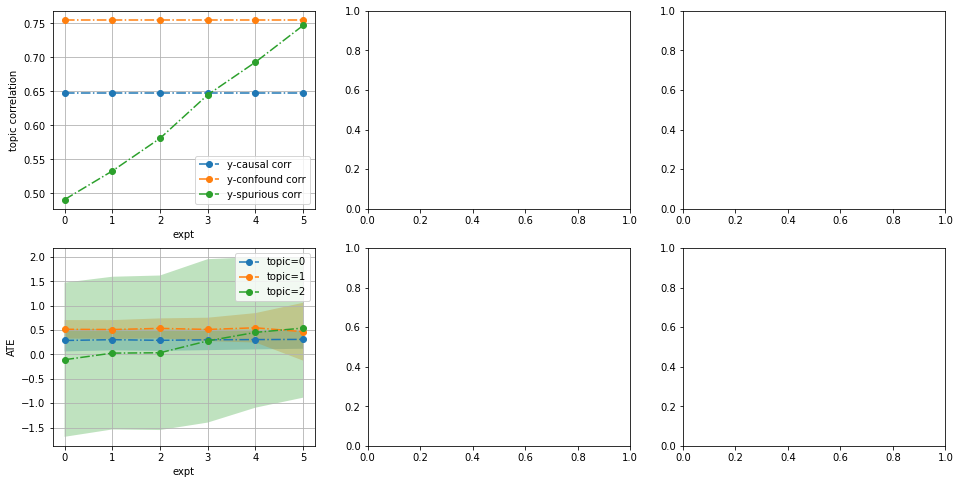

Bad pipe message: %s [b"?\x19\x10\x16\xc3\xf2\xf3\xe9b\xa2\x83GXK\x9f\xe5\xac\xf2\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x000\x00.\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x03\x03\x02\x03\x03", b'']
Bad pipe message: %s [b'', b'\x02']
Bad pipe message: %s [b'\x05\x02\x06']
Bad pipe message: %s [b'"^\xfei\xfdM\x9a\xc5\x88Y\xb4i\xa3\rvkEW\x00\x00\xa2\xc0\x14\xc

In [15]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
# Plot the results
# noise_list=[0.0,0.1,0.3]
plt,ax = plt.subplots(2,3)

for nidx,noise in enumerate(noise_list):
    #Plotting the correlation between topic and main label
    topic0_corr_list = [all_label_corr_dict_toy3[(num_sample_list[-1],noise,pvaltsp)][0][1] for pvaltsp in pvaltsp_list]
    topic1_corr_list = [all_label_corr_dict_toy3[(num_sample_list[-1],noise,pvaltsp)][0][2] for pvaltsp in pvaltsp_list]
    topic2_corr_list = [all_label_corr_dict_toy3[(num_sample_list[-1],noise,pvaltsp)][0][3] for pvaltsp in pvaltsp_list]

    ax[0,nidx].plot(topic0_corr_list,marker="o",ls="-.",label="y-causal corr")
    ax[0,nidx].plot(topic1_corr_list,marker="o",ls="-.",label="y-confound corr")
    ax[0,nidx].plot(topic2_corr_list,marker="o",ls="-.",label="y-spurious corr")

    ax[0,nidx].set_ylabel("topic correlation")
    ax[0,nidx].set_xlabel("expt")
    ax[0,nidx].legend()
    ax[0,nidx].grid(True)


    #Plotting the ATE for each experiment
    for treated_topic in treated_topics:
        #Getting the ATE for each of of pval variation
        ate = [all_result_dict_toy3[(num_sample_list[-1],noise,pvaltsp,treated_topic)]["ate"] for pvaltsp in pvaltsp_list]
        ate_lb = [all_result_dict_toy3[(num_sample_list[-1],noise,pvaltsp,treated_topic)]["lb"] for pvaltsp in pvaltsp_list]
        ate_ub = [all_result_dict_toy3[(num_sample_list[-1],noise,pvaltsp,treated_topic)]["ub"] for pvaltsp in pvaltsp_list]

        #Plotting the result for this topic
        expt_list = range(len(ate))
        ax[1,nidx].plot(expt_list,ate,marker="o",ls="-.",label="topic={}".format(treated_topic))
        ax[1,nidx].fill_between(expt_list,ate_lb,ate_ub,alpha=0.3)
    ax[1,nidx].set_ylabel("ATE")
    ax[1,nidx].set_xlabel("expt")
    ax[1,nidx].legend()
    ax[1,nidx].grid(True)

plt.show()

## Forest Regressor

### Sample =1k

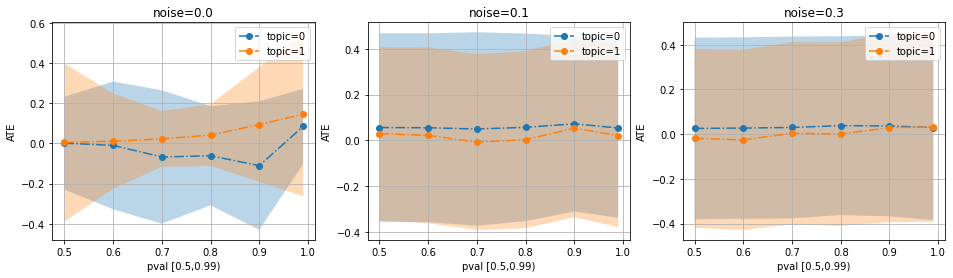

In [48]:
noise_list=[0.0,0.1,0.3] 
plot_one_result_set(all_result_dict,pval_list,treated_topics,num_sample,noise_list)

### Sample=10k

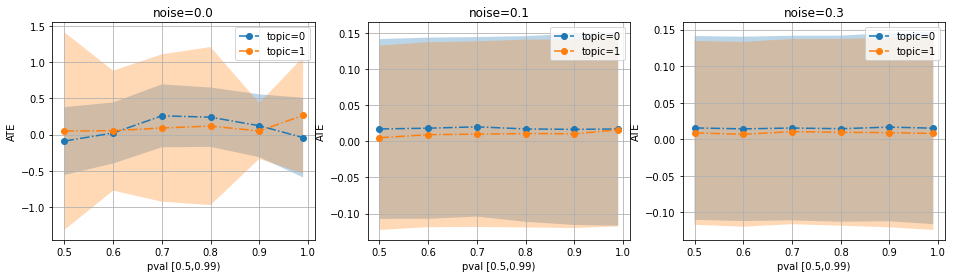

In [56]:
noise_list=[0.0,0.1,0.3] 
plot_one_result_set(all_result_dict,pval_list,treated_topics,num_sample,noise_list)

In [57]:
all_result_dict_forest

{(1000, 0.0, 0.5, 0): {'ate': 0.0012169923231688414,
  'lb': -0.2301048745217517,
  'ub': 0.23253885916808933},
 (1000, 0.0, 0.5, 1): {'ate': 0.004592074913846072,
  'lb': -0.3898362074494538,
  'ub': 0.39902035727714585},
 (1000, 0.0, 0.6, 0): {'ate': -0.009888649547607308,
  'lb': -0.3278708330827602,
  'ub': 0.30809353398754546},
 (1000, 0.0, 0.6, 1): {'ate': 0.01108671811729485,
  'lb': -0.22662102545986038,
  'ub': 0.24879446169445005},
 (1000, 0.0, 0.7, 0): {'ate': -0.06747897420805499,
  'lb': -0.40010966505096013,
  'ub': 0.26515171663485004},
 (1000, 0.0, 0.7, 1): {'ate': 0.02229274519300866,
  'lb': -0.11675427434955514,
  'ub': 0.16133976473557243},
 (1000, 0.0, 0.8, 0): {'ate': -0.06169624337294342,
  'lb': -0.30855216459431833,
  'ub': 0.18515967784843157},
 (1000, 0.0, 0.8, 1): {'ate': 0.041677006368761385,
  'lb': -0.11222943668536135,
  'ub': 0.1955834494228841},
 (1000, 0.0, 0.9, 0): {'ate': -0.11073589440453818,
  'lb': -0.43102659807307936,
  'ub': 0.2095548092640029

In [59]:
all_result_dict_forest = all_result_dict.copy()
all_result_dict_forest

{(1000, 0.0, 0.5, 0): {'ate': 0.0012169923231688414,
  'lb': -0.2301048745217517,
  'ub': 0.23253885916808933},
 (1000, 0.0, 0.5, 1): {'ate': 0.004592074913846072,
  'lb': -0.3898362074494538,
  'ub': 0.39902035727714585},
 (1000, 0.0, 0.6, 0): {'ate': -0.009888649547607308,
  'lb': -0.3278708330827602,
  'ub': 0.30809353398754546},
 (1000, 0.0, 0.6, 1): {'ate': 0.01108671811729485,
  'lb': -0.22662102545986038,
  'ub': 0.24879446169445005},
 (1000, 0.0, 0.7, 0): {'ate': -0.06747897420805499,
  'lb': -0.40010966505096013,
  'ub': 0.26515171663485004},
 (1000, 0.0, 0.7, 1): {'ate': 0.02229274519300866,
  'lb': -0.11675427434955514,
  'ub': 0.16133976473557243},
 (1000, 0.0, 0.8, 0): {'ate': -0.06169624337294342,
  'lb': -0.30855216459431833,
  'ub': 0.18515967784843157},
 (1000, 0.0, 0.8, 1): {'ate': 0.041677006368761385,
  'lb': -0.11222943668536135,
  'ub': 0.1955834494228841},
 (1000, 0.0, 0.9, 0): {'ate': -0.11073589440453818,
  'lb': -0.43102659807307936,
  'ub': 0.2095548092640029

## Causal Forest DML

### sample = 1k, num_estimators =1k

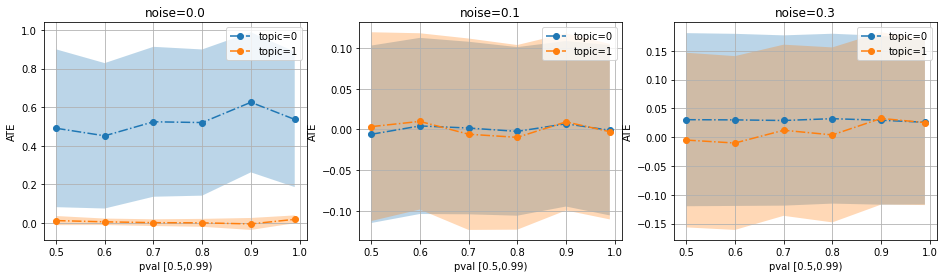

In [69]:
noise_list=[0.0,0.1,0.3] 
plot_one_result_set(all_result_dict,pval_list,treated_topics,num_sample,noise_list)

In [70]:
all_result_dict_cforest = all_result_dict.copy()
all_result_dict_cforest

{(1000, 0.0, 0.5, 0): {'ate': 0.4908237108082849,
  'lb': 0.0818682362121618,
  'ub': 0.8997791854044083},
 (1000, 0.0, 0.5, 1): {'ate': 0.012250191991173007,
  'lb': -0.011486882372783138,
  'ub': 0.03598726635512916},
 (1000, 0.0, 0.6, 0): {'ate': 0.4516324781666265,
  'lb': 0.07487013793034689,
  'ub': 0.8283948184029062},
 (1000, 0.0, 0.6, 1): {'ate': 0.005968406250101883,
  'lb': -0.010853231235092934,
  'ub': 0.022790043735296698},
 (1000, 0.0, 0.7, 0): {'ate': 0.5243336037014262,
  'lb': 0.13590258334374408,
  'ub': 0.9127646240591077},
 (1000, 0.0, 0.7, 1): {'ate': 0.001514795695022146,
  'lb': -0.015990112540462145,
  'ub': 0.019019703930506428},
 (1000, 0.0, 0.8, 0): {'ate': 0.5203239950760407,
  'lb': 0.14154537430067912,
  'ub': 0.8991026158514014},
 (1000, 0.0, 0.8, 1): {'ate': 0.0006694565066363013,
  'lb': -0.01981661699184633,
  'ub': 0.021155530005118932},
 (1000, 0.0, 0.9, 0): {'ate': 0.6253111451251464,
  'lb': 0.2623092114338549,
  'ub': 0.9883130788164377},
 (1000,

### num_sample=1k, num_estimator=100

KeyError: (1000, 0.1, 0.5, 0)

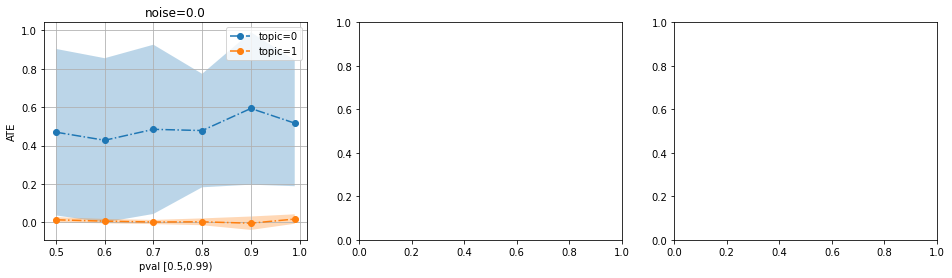

In [74]:
noise_list=[0.0,0.1,0.3] 
plot_one_result_set(all_result_dict,pval_list,treated_topics,num_sample,noise_list)

### causal forest noise via pval_main (t0 here)

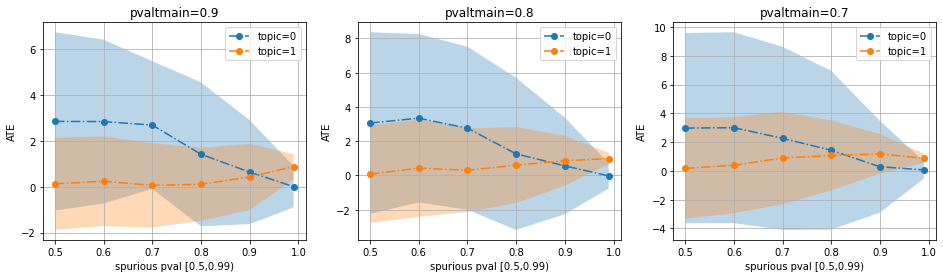

In [41]:
pvalt0_list=[0.9,0.8,0.7]
all_result_dict_cf=all_result_dict_cf.copy()|all_result_dict.copy()
plot_one_result_set(all_result_dict_cf,pvalt0_list,pvalt1_list,treated_topics,num_sample,noise_list)